## Usage of KNeighbourRegressor for energy forecasting
This notebook uses the Building Data Genome Project data set to analyze electrical meter data from non-residential buildings.

Link to Dataset: https://github.com/buds-lab/building-data-genome-project-2/tree/master/data

## Import relevant python packages

Let's use the electrical meter data to create clusters of typical load profiles for analysis. 

In [1]:
###############################
'''
Archisman Chakraborti
Harish Chandar Research Institure(HRI), Prayagraj
Department of Atomic Ebergy(DAE), Govt. of West Bengal
'''
################################

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np

# Print versions
print("python version", sys.version)
print("numpy version", np.__version__)
print("matplotlib version", plt.matplotlib.__version__)
print("pandas version", pd.__version__)

python version 3.11.3 (v3.11.3:f3909b8bc8, Apr  4 2023, 20:12:10) [Clang 13.0.0 (clang-1300.0.29.30)]
numpy version 1.24.3
matplotlib version 3.7.1
pandas version 2.0.1


Next let's load all the packages we will need for  analysis

In [2]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from datetime import datetime

# Electricity Prediction for Measurement and Verification

Prediction is a common machine learning (ML) technique used on building energy consumption data.  

The graphic below comes from the IPMVP to show how prediction can be used for M&V to calculate how much energy **would have** been consumed if an energy savings intervention had not been implemented. 



## Prediction for Measurement and Verification

![alt text](https://raw.githubusercontent.com/buds-lab/the-building-data-genome-project/master/docs/edx-graphics/EDX-ML-ScikitLearn-3.png)

There is an open publication that gives more information on how prediction in this realm can be approached: https://www.mdpi.com/2504-4990/1/3/56



## Load electricity data and weather data


In [3]:
elec_all_data = pd.read_csv("https://media.githubusercontent.com/media/buds-lab/building-data-genome-project-2/master/data/meters/cleaned/electricity_cleaned.csv", 
                            index_col='timestamp', parse_dates=True)
elec_all_data.head(5)

,Panther_parking_Lorriane,Panther_lodging_Cora,Panther_office_Hannah,Panther_lodging_Hattie,Panther_education_Teofila,Panther_education_Jerome,Panther_retail_Felix,Panther_parking_Asia,Panther_education_Misty,Panther_retail_Gilbert,...,Cockatoo_public_Caleb,Cockatoo_education_Tyler,Cockatoo_public_Shad,Mouse_health_Buddy,Mouse_health_Modesto,Mouse_lodging_Vicente,Mouse_health_Justin,Mouse_health_Ileana,Mouse_health_Estela,Mouse_science_Micheal
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,123.200,727.575,69.200,8.8224,370.0870,10.0,282.9965,26.0,135.0,168.2243
2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,126.475,731.200,66.275,17.6449,737.8260,30.0,574.9265,51.0,265.0,336.4486
2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,127.825,724.675,64.675,17.6449,729.9255,30.0,570.2780,50.0,272.0,336.4486
2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130.475,737.375,65.875,17.6449,722.2620,20.0,561.1470,52.0,276.0,336.4486
2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,129.675,721.150,66.275,17.6449,719.1665,30.0,564.3695,50.0,280.0,336.4486


In [4]:
elec_all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 1578 entries, Panther_parking_Lorriane to Mouse_science_Micheal
dtypes: float64(1578)
memory usage: 211.3 MB


<Axes: title={'center': 'Dtypes of data'}>

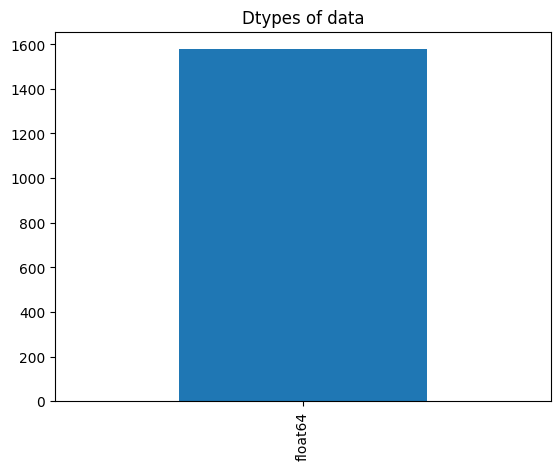

In [5]:
elec_all_data.dtypes.value_counts().plot(kind = "bar", title = "Dtypes of data")

In [6]:
elec_all_data.columns

Index(['Panther_parking_Lorriane', 'Panther_lodging_Cora',
       'Panther_office_Hannah', 'Panther_lodging_Hattie',
       'Panther_education_Teofila', 'Panther_education_Jerome',
       'Panther_retail_Felix', 'Panther_parking_Asia',
       'Panther_education_Misty', 'Panther_retail_Gilbert',
       ...
       'Cockatoo_public_Caleb', 'Cockatoo_education_Tyler',
       'Cockatoo_public_Shad', 'Mouse_health_Buddy', 'Mouse_health_Modesto',
       'Mouse_lodging_Vicente', 'Mouse_health_Justin', 'Mouse_health_Ileana',
       'Mouse_health_Estela', 'Mouse_science_Micheal'],
      dtype='object', length=1578)

In [136]:
# Select the building for which we want to do the forecasting
buildingname = 'Panther_lodging_Hattie'

<AxesSubplot:xlabel='timestamp'>

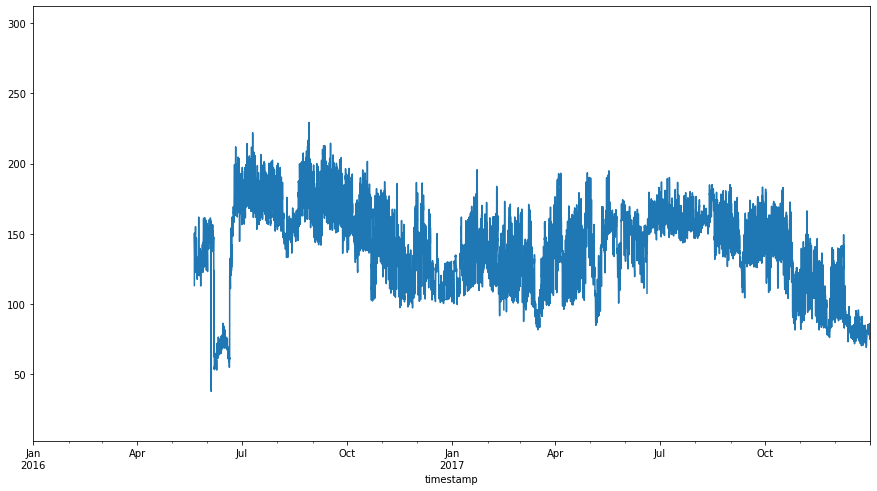

In [137]:
elec_all_data[buildingname].plot(kind = "line", figsize = (15, 8))

The dara strats from about April, 2016. So, we will use that portion of the data

In [138]:
office_example_prediction_data = pd.DataFrame(elec_all_data[buildingname]\
                                              .truncate(before='2016-07-01'))\
                                              .fillna(method='ffill')

Instead of using the 'ffill' method , we could have also used a knn based algorithm or a newton interpolation.

<AxesSubplot:xlabel='timestamp'>

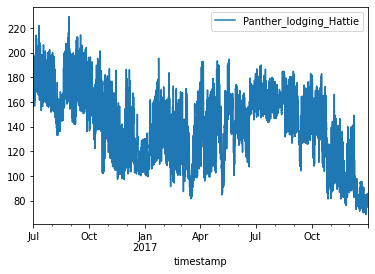

In [139]:
office_example_prediction_data.plot(kind = "line")

In [140]:
office_example_prediction_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13176 entries, 2016-07-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Panther_lodging_Hattie  13176 non-null  float64
dtypes: float64(1)
memory usage: 205.9 KB


In [141]:
weather_data = pd.read_csv("https://media.githubusercontent.com/media/buds-lab/building-data-genome-project-2/master/data/weather/weather.csv",
                           index_col='timestamp', parse_dates=True)
weather_data.head()

,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
timestamp,,,,,,,,,
2016-01-01 00:00:00,Panther,19.4,NaN,19.4,0.0,NaN,NaN,0.0,0.0
2016-01-01 01:00:00,Panther,21.1,6.0,21.1,-1.0,NaN,1019.4,0.0,0.0
2016-01-01 02:00:00,Panther,21.1,NaN,21.1,0.0,NaN,1018.8,210.0,1.5
2016-01-01 03:00:00,Panther,20.6,NaN,20.0,0.0,NaN,1018.1,0.0,0.0
2016-01-01 04:00:00,Panther,21.1,NaN,20.6,0.0,NaN,1019.0,290.0,1.5


In [34]:
weather_data_site = weather_data.query("site_id == 'Panther'").truncate(before='2016-07-01')

In [35]:
weather_data_site.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13176 entries, 2016-07-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   site_id         13176 non-null  object 
 1   airTemperature  13176 non-null  float64
 2   cloudCoverage   7633 non-null   float64
 3   dewTemperature  13176 non-null  float64
 4   precipDepth1HR  13167 non-null  float64
 5   precipDepth6HR  494 non-null    float64
 6   seaLvlPressure  12915 non-null  float64
 7   windDirection   12799 non-null  float64
 8   windSpeed       13176 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


In [36]:
weather_hourly = weather_data_site.resample("H").mean()
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

<AxesSubplot:title={'center':'Temperature plot'}, xlabel='timestamp'>

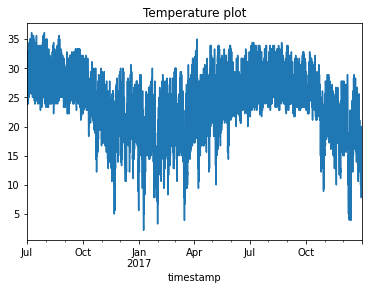

In [39]:
temperature = weather_hourly_nooutlier_nogaps["airTemperature"]
temperature.plot(title = "Temperature plot")


## Create Train and Test Datasets

 In this case, we will use a few simple time series features as well as outdoor air temperature to predict how much energy a building uses.

For this demonstration, we will use four months of data from Mrach, April, May, and June to prediction July.

In [40]:
training_months = [3, 4,5,6]
test_months = [7]

We can divide the data set by using the `datetime index` of the data frame and a function known as `.isin` to extract the months for the model

In [46]:
trainingdata = office_example_prediction_data[office_example_prediction_data\
                                              .index.month.isin(training_months)]
testdata = office_example_prediction_data[office_example_prediction_data\
                                          .index.month.isin(test_months)]

In [44]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2017-03-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Panther_lodging_Hattie  2928 non-null   float64
dtypes: float64(1)
memory usage: 45.8 KB


In [45]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1488 entries, 2016-07-01 00:00:00 to 2017-07-31 23:00:00
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Panther_lodging_Hattie  1488 non-null   float64
dtypes: float64(1)
memory usage: 23.2 KB


We can extract the training input data features that will go into the model and the training **label** data which is what are are targeting to predict. 

## Encoding Categorical Variables 

We use OneHotEncoding through the pandas `.get_dummies()` function to change the temporal variables of *time of day* and *day of week* into categories that the model can use more effectively)

In [47]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour), 
                                     pd.get_dummies(trainingdata.index.dayofweek), 
                                     pd.DataFrame(temperature[temperature\
                                                              .index.month\
                                                              .isin(training_months)].values)], axis=1).dropna()


In [48]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,20.6
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,20.0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,20.0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,19.4
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,18.9


## Train a K-Neighbor Model

This model was chosen after a thorough grid search of models because it performed well on the chosen metrics.

In [49]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));


In [50]:
# Testing features
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature\
                                                             .index.month\
                                                             .isin(test_months)]\
                                                 .values)], axis=1).dropna())

# Hypertune the model using optuna

In [87]:
import optuna
from sklearn.model_selection import train_test_split

In [112]:
knn= KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [124]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(np.array(train_features), 
                                                    np.array(trainingdata.values), 
                                                    test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameters to tune
    n_neighbors = trial.suggest_int('n_neighbors', 1, 100)  # Larger range for n_neighbors
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])  # Only two options for p
    leaf_size = trial.suggest_int("leaf_size", 1, 100)
    
    # Create a KNN regressor with the suggested hyperparameters
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights,
                              p=p, leaf_size = leaf_size)
    
    # Train the model
    knn.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = knn.predict(X_test)
    
    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

if __name__ == "__main__":
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100, show_progress_bar = True)
    
    print("Number of finished trials: ", len(study.trials))
    
    print("Best trial:")
    trial = study.best_trial
    
    print("Value: ", trial.value)
    
    print("Params: ")
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2023-08-14 07:03:44,100] A new study created in memory with name: no-name-3981586c-58d7-4ed3-a1a4-3795976d1938
/opt/conda/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-14 07:03:44,180] Trial 0 finished with value: 260.6746597411627 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'p': 2, 'leaf_size': 21}. Best is trial 0 with value: 260.6746597411627.
[I 2023-08-14 07:03:44,223] Trial 1 finished with value: 186.19300179716316 and parameters: {'n_neighbors': 52, 'weights': 'uniform', 'p': 1, 'leaf_size': 86}. Best is trial 1 with value: 186.19300179716316.
[I 2023-08-14 07:03:44,272] Trial 2 finished with value: 184.47483392294623 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'p': 1, 'leaf_size': 49}. Best is trial 2 with value: 184.47483392294623.
[I 2023-08-14 07:03:44,299] Trial 3 finished with value: 194.09493256890195 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'p': 2, 'leaf_size': 63}. Best is trial 2 with value: 184.47483392294623.
[I 2023-08-14 07:03:44,338] Trial 4 finished with value: 190.19379175635052 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'p': 1, 'leaf_size': 31}. Best is tr

## Use the best params

In [125]:
# Use the best params to train a KNN regressor on the entire dataset
best_n_neighbors = trial.params['n_neighbors']
best_weights = trial.params['weights']
best_p = trial.params['p']
best_leaf_size = trial.params["leaf_size"]
    
best_knn = KNeighborsRegressor(n_neighbors=best_n_neighbors, weights=best_weights, p=best_p, 
                              leaf_size = best_leaf_size)
best_knn.fit(np.array(train_features), np.array(trainingdata.values))

KNeighborsRegressor(leaf_size=42, n_neighbors=32)



## Use the Model to predict for the *Test* period


In [126]:
predictions = best_knn.predict(test_features)

In [127]:
# We create a datafrane of the predicted vs actual data
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, 
                                                        index=testdata.index)], axis=1)
predicted_vs_actual.columns = ["Actual", "Predicted"]
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2016-07-01 00:00:00,172.6733,149.703891
2016-07-01 01:00:00,173.2334,153.169562
2016-07-01 02:00:00,168.5925,149.148781
2016-07-01 03:00:00,167.2323,148.798712
2016-07-01 04:00:00,164.2717,148.466147


<AxesSubplot:xlabel='timestamp'>

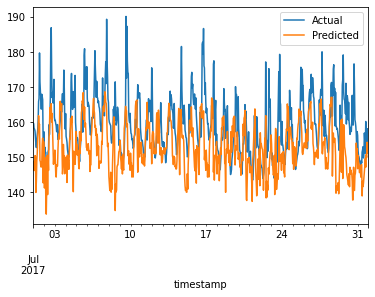

In [128]:
predicted_vs_actual.truncate(before='2017-07-01').plot(kind = "line")

## Evaluation metrics

In order to understand quanitatively how the model performed, we can use various evaluation metrics to understand how well the model compared to reality. 

In this situation, let's use the error metric [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)   
We can also use, Root mean Square Error or Mean Absolute error

In [129]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

y_pred = predicted_vs_actual["Predicted"].values
y_true = predicted_vs_actual["Actual"].values

def get_metrics(y_true:np.ndarray, y_pred:np.ndarray) -> pd.DataFrame:
    mse = mean_squared_error(y_true = y_true, y_pred = y_pred)
    mae = mean_absolute_error(y_true = y_true, y_pred = y_pred)
    rmse = np.sqrt(mse)
    mape = np.sum(np.abs((y_pred - y_true)/y_true))/len(y_true)
    
    metrics = {
        "MAE" : mae, 
        "MSE" : mse,
        "RMSE" : rmse, 
        "MAPE" : mape
    }
    return pd.DataFrame(metrics, index = [0])

In [130]:
get_metrics(y_true=y_true, y_pred=y_pred)

,MAE,MSE,RMSE,MAPE
0,16.078567,414.468176,20.358491,0.090544
